## A. Importing Necessary Libraries

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
import shap
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


## B. Generating Synthetic Data and Feature Engineering

In [2]:
np.random.seed(42)
num_records = 5000
CustomerID = np.arange(1, num_records + 1)

# Age 
Age = np.random.normal(loc=40, scale=12, size=num_records).astype(int)
Age = np.clip(Age, 18, 80)

# Gender 
Gender = np.random.choice(['Male', 'Female'], size=num_records)

# ContractType (skewed distribution towards Month-to-Month)
ContractType = np.random.choice(['Month-to-month', 'One year', 'Two year'], 
                                size=num_records, 
                                p=[0.6, 0.2, 0.2])

# MonthlyCharges (skewed distribution)
MonthlyCharges = np.random.normal(loc=65, scale=35, size=num_records)
MonthlyCharges = np.clip(MonthlyCharges, 18.0, 150.0)
MonthlyCharges = np.round(MonthlyCharges, 2)

# TotalCharges (correlates with Tenure and MonthlyCharges)
Tenure = np.random.randint(0, 72, size=num_records)
TotalCharges = MonthlyCharges * Tenure
TotalCharges = np.round(TotalCharges, 2)

# TechSupport (correlates with ContractType)
TechSupport = np.where(ContractType == 'Month-to-month', 
                       np.random.choice(['Yes', 'No'], p=[0.3, 0.7], size=num_records),
                       np.random.choice(['Yes', 'No'], p=[0.7, 0.3], size=num_records))

# InternetService 
InternetService = np.random.choice(['DSL', 'Fiber optic', 'No'], size=num_records, p=[0.4, 0.4, 0.2])

# PaperlessBilling (correlates with ContractType)
PaperlessBilling = np.where(ContractType == 'Month-to-month', 
                            np.random.choice(['Yes', 'No'], p=[0.8, 0.2], size=num_records),
                            np.random.choice(['Yes', 'No'], p=[0.3, 0.7], size=num_records))

# PaymentMethod 
PaymentMethod = np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], 
                                 size=num_records)

# AverageMonthlyCharges and CustomerLifetimeValue
AverageMonthlyCharges = TotalCharges / np.where(Tenure == 0, 1, Tenure)
CustomerLifetimeValue = MonthlyCharges * Tenure

# Churn (Our Target Variable) 
Churn = np.where((ContractType == 'Month-to-month') & (TechSupport == 'No') & (MonthlyCharges > 80), 
                 'Yes', 'No')


df = pd.DataFrame({
    'CustomerID': CustomerID,
    'Age': Age,
    'Gender': Gender,
    'ContractType': ContractType,
    'MonthlyCharges': MonthlyCharges,
    'TotalCharges': TotalCharges,
    'TechSupport': TechSupport,
    'InternetService': InternetService,
    'Tenure': Tenure,
    'PaperlessBilling': PaperlessBilling,
    'PaymentMethod': PaymentMethod,
    'Churn': Churn,
    'AverageMonthlyCharges': np.round(AverageMonthlyCharges, 2),
    'CustomerLifetimeValue': np.round(CustomerLifetimeValue, 2)
})

# Introduce missing values (as before) and outliers
df.loc[np.random.choice(df.index, size=250, replace=False), 'TotalCharges'] = np.nan
df.loc[np.random.choice(df.index, size=250, replace=False), 'AverageMonthlyCharges'] = np.nan

# Feature Engineering

# Creating Tenure Groups
df['TenureGroup'] = pd.cut(df['Tenure'], bins=[0, 12, 24, np.inf], labels=['New', 'Intermediate', 'Long-term'])


# Calculating Total Charges per Month (if Tenure > 0)
df['TotalChargesPerMonth'] = df['TotalCharges'] / np.where(df['Tenure'] > 0, df['Tenure'], 1)

# Categorizing PaymentMethod into Electronic and Non-Electronic
df['Electronic'] = df['PaymentMethod'].apply(lambda x: 'Electronic' if 'Credit' in x or 'Bank' in x else 'Non-Electronic')

# Interaction Terms
df['MonthlyCharges_Tenure'] = df['MonthlyCharges'] * df['Tenure']
df['Internet_TechSupport'] = ((df['InternetService'] != 'No') & (df['TechSupport'] != 'No')).astype(int)

# Log Transformation of Total Charges
df['LogTotalCharges'] = np.log(df['TotalCharges'].replace(0, np.nan))  # Handle zero values to avoid log(0)

df.head()


,CustomerID,Age,Gender,ContractType,MonthlyCharges,TotalCharges,TechSupport,InternetService,Tenure,PaperlessBilling,PaymentMethod,Churn,AverageMonthlyCharges,CustomerLifetimeValue,TenureGroup,TotalChargesPerMonth,Electronic,MonthlyCharges_Tenure,Internet_TechSupport,LogTotalCharges
0,1,45,Female,Month-to-month,124.23,5714.58,Yes,DSL,46,Yes,Bank transfer,No,124.23,5714.58,Long-term,124.23,Electronic,5714.58,1,8.650776
1,2,38,Male,Month-to-month,55.91,3801.88,No,Fiber optic,68,Yes,Credit card,No,55.91,3801.88,Long-term,55.91,Electronic,3801.88,0,8.243251
2,3,47,Female,Two year,66.24,1523.52,Yes,DSL,23,No,Credit card,No,66.24,1523.52,Intermediate,66.24,Electronic,1523.52,1,7.328779
3,4,58,Female,Month-to-month,26.97,1887.90,Yes,No,70,Yes,Mailed check,No,26.97,1887.90,Long-term,26.97,Non-Electronic,1887.90,0,7.543220
4,5,37,Female,Month-to-month,38.01,1254.33,No,No,33,Yes,Mailed check,No,38.01,1254.33,Long-term,38.01,Non-Electronic,1254.33,0,7.134357


## C. Exploratory Data Analysis

### 1. Check for missing values in the dataset
 

In [3]:
missing_values_updated = df.isnull().sum()
print("Missing Values in Each Column:")
missing_values_updated

Missing Values in Each Column:


CustomerID                 0
Age                        0
Gender                     0
ContractType               0
MonthlyCharges             0
TotalCharges             250
TechSupport                0
InternetService            0
Tenure                     0
PaperlessBilling           0
PaymentMethod              0
Churn                      0
AverageMonthlyCharges    250
CustomerLifetimeValue      0
TenureGroup               70
TotalChargesPerMonth     250
Electronic                 0
MonthlyCharges_Tenure      0
Internet_TechSupport       0
LogTotalCharges          314
dtype: int64

In [4]:
# We notice that there are multiple columns with missing values we will deal with these after encoding the categorical variables

### 2. Summary statistics for numerical columns


In [5]:
numerical_summary = df.describe()
numerical_summary

,CustomerID,Age,MonthlyCharges,TotalCharges,Tenure,AverageMonthlyCharges,CustomerLifetimeValue,TotalChargesPerMonth,MonthlyCharges_Tenure,Internet_TechSupport,LogTotalCharges
count,5000.000000,5000.000000,5000.000000,4750.000000,5000.000000,4750.000000,5000.000000,4750.000000,5000.000000,5000.000000,4686.000000
mean,2500.500000,39.750000,66.943244,2374.165533,35.305800,65.882543,2372.244314,66.119775,2372.244314,0.364600,7.368049
std,1443.520003,11.557033,32.137563,1905.581443,20.765494,32.814398,1916.290788,32.884358,1916.290788,0.481366,1.070338
min,1.000000,18.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.890372
25%,1250.750000,32.000000,41.967500,859.680000,17.000000,40.762500,846.000000,41.060000,846.000000,0.000000,6.799189
50%,2500.500000,40.000000,65.600000,1877.065000,35.000000,64.860000,1869.425000,65.185000,1869.425000,0.000000,7.560135
75%,3750.250000,47.000000,89.072500,3495.085000,53.000000,88.485000,3487.637500,88.802500,3487.637500,1.000000,8.169702
max,5000.000000,80.000000,150.000000,10227.700000,71.000000,150.000000,10227.700000,150.000000,10227.700000,1.000000,9.232855


<Figure size 1200x800 with 0 Axes>

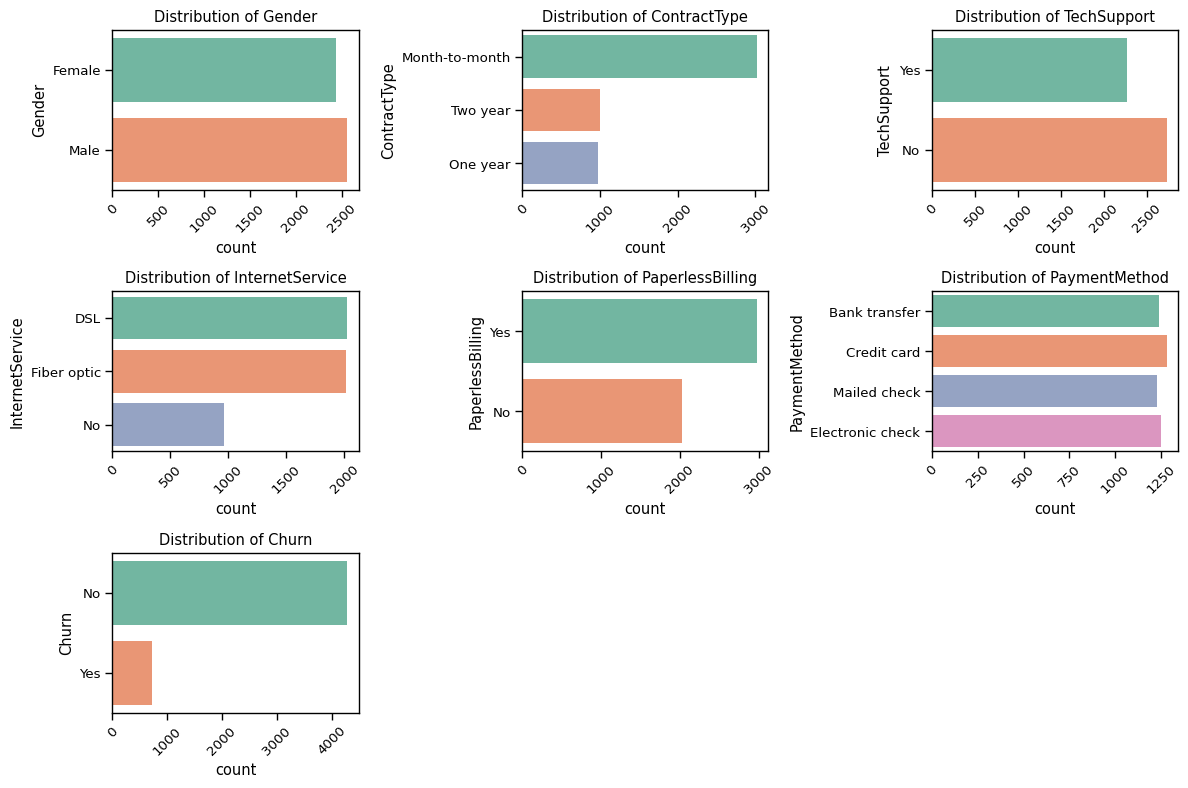

<Figure size 640x480 with 0 Axes>

In [83]:
plt.figure(figsize=(12, 8))
plt.figure(figsize=(12, 8))

for i, column in enumerate(['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod', 'Churn'], 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=column, data=df, hue=column, palette='Set2', legend=False)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
# plt.savefig('distribution.png', dpi=400)

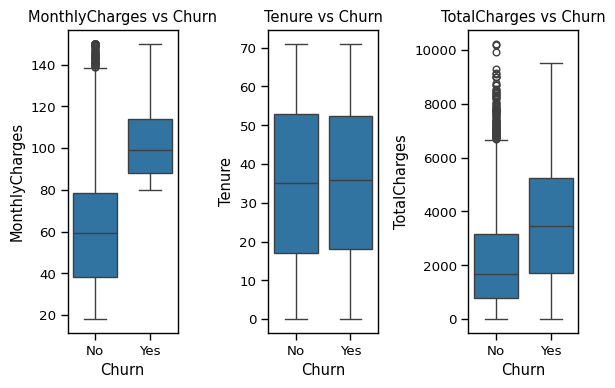

<Figure size 640x480 with 0 Axes>

In [84]:
# Visualizing relationships between numerical features and Churn
plt.figure(figsize=(6, 4))

# MonthlyCharges vs. Churn
plt.subplot(1, 3, 1)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('MonthlyCharges vs Churn')


# Tenure vs. Churn
plt.subplot(1, 3, 2)
sns.boxplot(x='Churn', y='Tenure', data=df)
plt.title('Tenure vs Churn')

# TotalCharges vs. Churn
plt.subplot(1, 3, 3)
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.title('TotalCharges vs Churn')

plt.tight_layout()
plt.show()
# plt.savefig('box-plots.png', dpi=300)

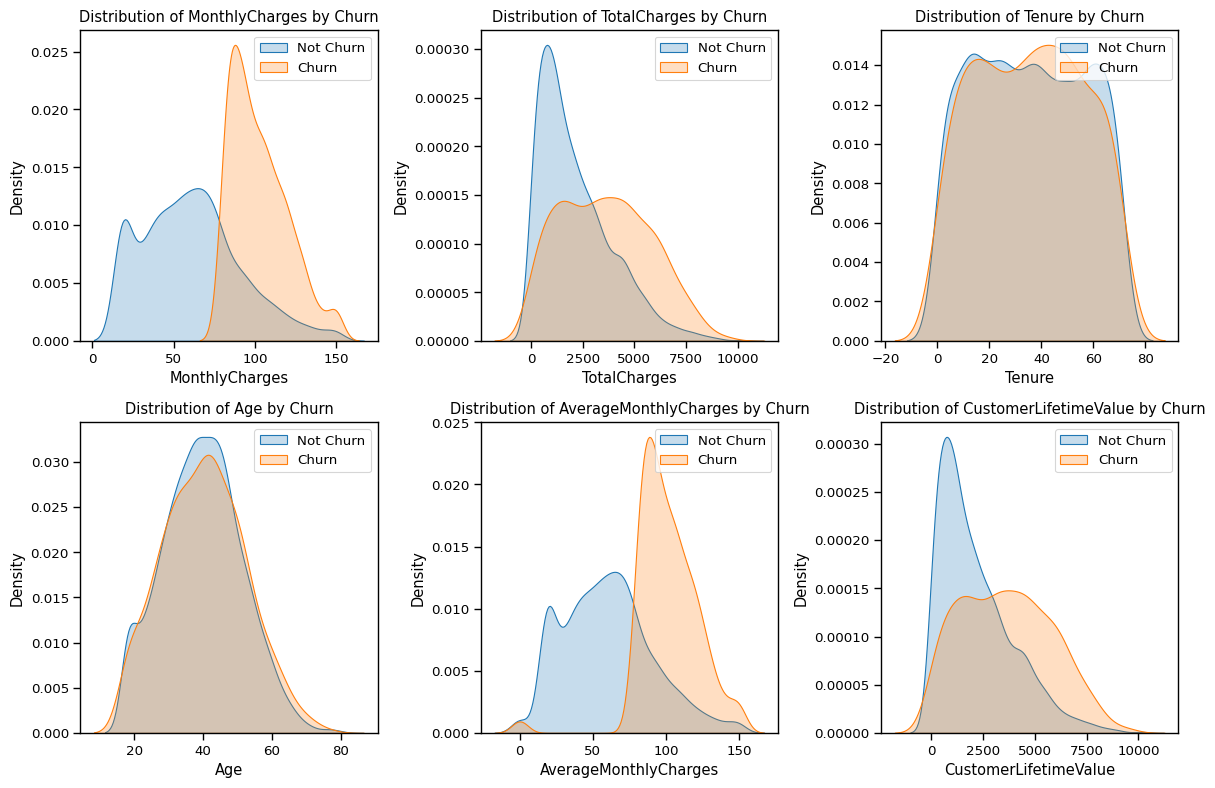

<Figure size 640x480 with 0 Axes>

In [85]:
sns.set_context("paper", font_scale=1.1)

features = ['MonthlyCharges', 'TotalCharges', 'Tenure', 'Age', 'AverageMonthlyCharges', 'CustomerLifetimeValue']
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    sns.kdeplot(df[feature][df["Churn"] == 'No'], shade=True, ax=ax)
    sns.kdeplot(df[feature][df["Churn"] == 'Yes'], shade=True, ax=ax)
    ax.set_title(f'Distribution of {feature} by Churn')
    ax.legend(["Not Churn", "Churn"], loc='upper right')
    ax.set_ylabel('Density')
    ax.set_xlabel(feature)

plt.tight_layout()
plt.show()
# plt.savefig('distribution-by-churn.png', dpi=300)

## D. Data Preprocessing

### 1. Encoding and Mapping Categorical and Ordinal Variables  

In [10]:
df_encoded = df.copy()

# 1. Encoding Ordinal Variables 
contract_mapping = {'Month-to-month': 1, 'One year': 2, 'Two year': 3}
df_encoded['ContractType'] = df_encoded['ContractType'].map(contract_mapping)

internet_service_mapping = {'No': 1, 'DSL': 2, 'Fiber optic': 3}
df_encoded['InternetService'] = df_encoded['InternetService'].map(internet_service_mapping)

tech_support_mapping = {'No': 1, 'Yes': 2}
df_encoded['TechSupport'] = df_encoded['TechSupport'].map(tech_support_mapping)

tenure_group_mapping = {'New': 1, 'Short-term': 2, 'Medium-term': 3, 'Long-term': 4}
df_encoded['TenureGroup'] = df_encoded['TenureGroup'].map(tenure_group_mapping)

electronic_mapping = {'Non-Electronic': 0, 'Electronic': 1}
df_encoded['Electronic'] = df_encoded['Electronic'].map(electronic_mapping)

# 2. Encode Nominal Categorical Variables using LabelEncoder (Gender, PaperlessBilling, PaymentMethod, Churn)
label_encoders = {}
for column in ['Gender', 'PaperlessBilling', 'PaymentMethod', 'Churn']:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le
df_encoded.head()


,CustomerID,Age,Gender,ContractType,MonthlyCharges,TotalCharges,TechSupport,InternetService,Tenure,PaperlessBilling,PaymentMethod,Churn,AverageMonthlyCharges,CustomerLifetimeValue,TenureGroup,TotalChargesPerMonth,Electronic,MonthlyCharges_Tenure,Internet_TechSupport,LogTotalCharges
0,1,45,0,1,124.23,5714.58,2,2,46,1,0,0,124.23,5714.58,4.0,124.23,1,5714.58,1,8.650776
1,2,38,1,1,55.91,3801.88,1,3,68,1,1,0,55.91,3801.88,4.0,55.91,1,3801.88,0,8.243251
2,3,47,0,3,66.24,1523.52,2,2,23,0,1,0,66.24,1523.52,NaN,66.24,1,1523.52,1,7.328779
3,4,58,0,1,26.97,1887.90,2,1,70,1,3,0,26.97,1887.90,4.0,26.97,0,1887.90,0,7.543220
4,5,37,0,1,38.01,1254.33,1,1,33,1,3,0,38.01,1254.33,4.0,38.01,0,1254.33,0,7.134357


### 2. Imputation

In [11]:

# Creating lists for numerical and categorical columns
numeric_columns = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df_encoded.select_dtypes(exclude=[np.number]).columns.tolist()

# Filling the missing values in numerical columns
for column in numeric_columns:
    if df_encoded[column].isnull().sum() > 0:
        # Fill with median for numerical columns
        df_encoded[column].fillna(df_encoded[column].median(), inplace=True)

# Filling the missing values in categorical columns
for column in categorical_columns:
    if df_encoded[column].isnull().sum() > 0:
        # Fill with mode for categorical columns
        df_encoded[column].fillna(df_encoded[column].mode()[0], inplace=True)

print(df_encoded.isnull().sum())

CustomerID               0
Age                      0
Gender                   0
ContractType             0
MonthlyCharges           0
TotalCharges             0
TechSupport              0
InternetService          0
Tenure                   0
PaperlessBilling         0
PaymentMethod            0
Churn                    0
AverageMonthlyCharges    0
CustomerLifetimeValue    0
TenureGroup              0
TotalChargesPerMonth     0
Electronic               0
MonthlyCharges_Tenure    0
Internet_TechSupport     0
LogTotalCharges          0
dtype: int64


### Correlations

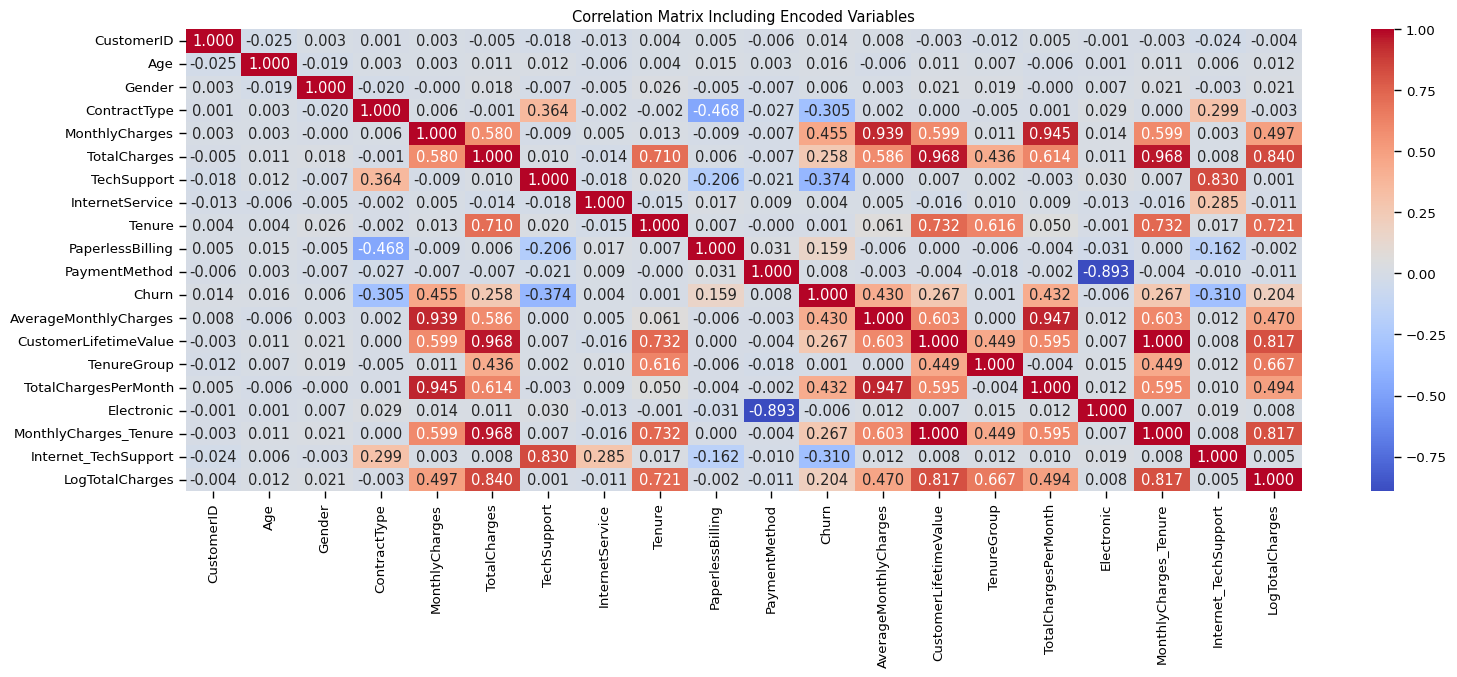

In [12]:
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Matrix Including Encoded Variables')
plt.show()

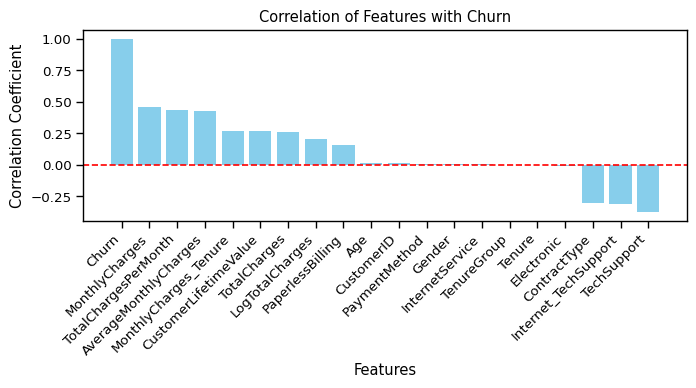

<Figure size 640x480 with 0 Axes>

In [86]:
churn_corr = correlation_matrix['Churn'].sort_values(ascending=False)
plt.figure(figsize=(7, 4))
plt.bar(churn_corr.index, churn_corr.values, color='skyblue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.title('Correlation of Features with Churn')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.tight_layout()
plt.show()
# plt.savefig('correlation-with-churn.png', dpi=300)

### Removing the irrelevant features to limit the feature selection for further training

In [21]:
low_corr_features = churn_corr[churn_corr.abs() < 0.05].index.tolist()
low_corr_features.remove('CustomerID')
print(f"Features with low correlation to Churn: {low_corr_features}")

# remove the least correlated features from the dataset
df_reduced = df_encoded.drop(columns=low_corr_features)

Features with low correlation to Churn: ['Age', 'PaymentMethod', 'Gender', 'InternetService', 'TenureGroup', 'Tenure', 'Electronic']


In [22]:
# We have now dropped 7 columns whilst keeping customerID for referencing
print(df_encoded.shape)
print(df_reduced.shape)

(5000, 20)
(5000, 13)


### Train Test Splitting

In [23]:
X = df_reduced.drop('Churn', axis=1)  
y = df_reduced['Churn']               # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train:{X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")

X_train:(4000, 12), y_train: (4000,)
X_test: (1000, 12),  y_test: (1000,)


<br><br><br>

## E. Training Multiple models in their best form and evaluating results

### 1. Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       856
           1       0.92      0.84      0.88       144

    accuracy                           0.97      1000
   macro avg       0.95      0.91      0.93      1000
weighted avg       0.97      0.97      0.97      1000

AUC: 0.99


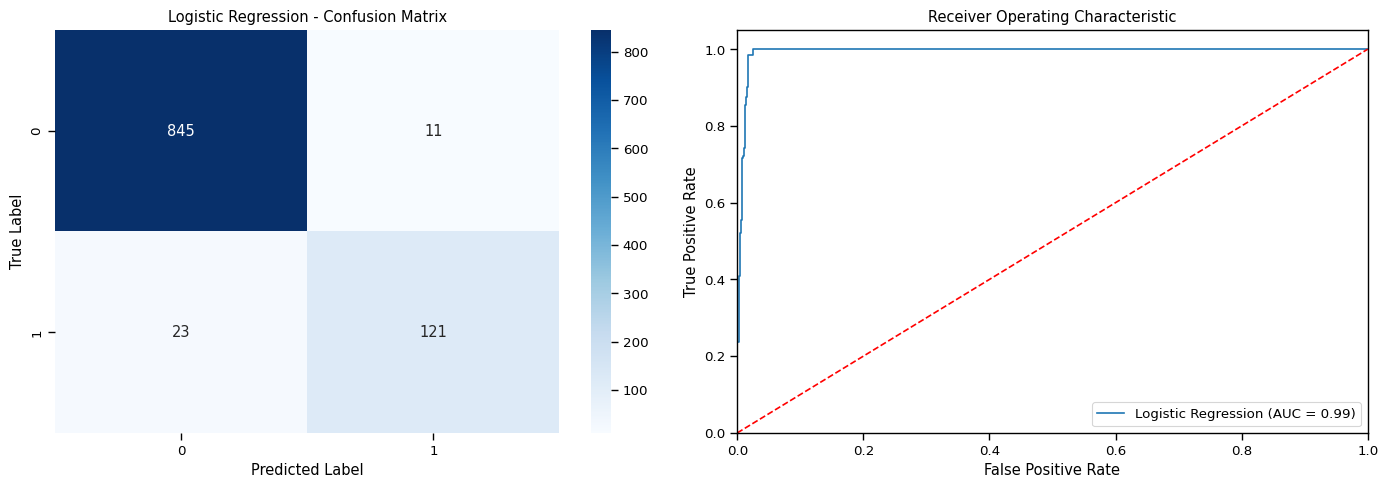

<Figure size 640x480 with 0 Axes>

In [87]:
# Logistic Regression Model
log_reg = LogisticRegression()

# Hyperparameter Optimization
param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid_log_reg = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_log_reg.fit(X_train, y_train)

# Getting the Best Model
best_log_reg = grid_log_reg.best_estimator_
y_pred = best_log_reg.predict(X_test)

# Evaluation 
# Classification Report
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, best_log_reg.predict_proba(X_test)[:,1]):.2f}")


fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Logistic Regression - Confusion Matrix")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_log_reg.predict_proba(X_test)[:,1])
ax[1].plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc_score(y_test, best_log_reg.predict_proba(X_test)[:,1]))
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()
# plt.savefig('logreg.png', dpi=300)



<br>
<br>
<br>
<br>

### **( Ensemble Methods )**

### 2. Random Forest 

AUC: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       856
           1       1.00      0.99      1.00       144

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



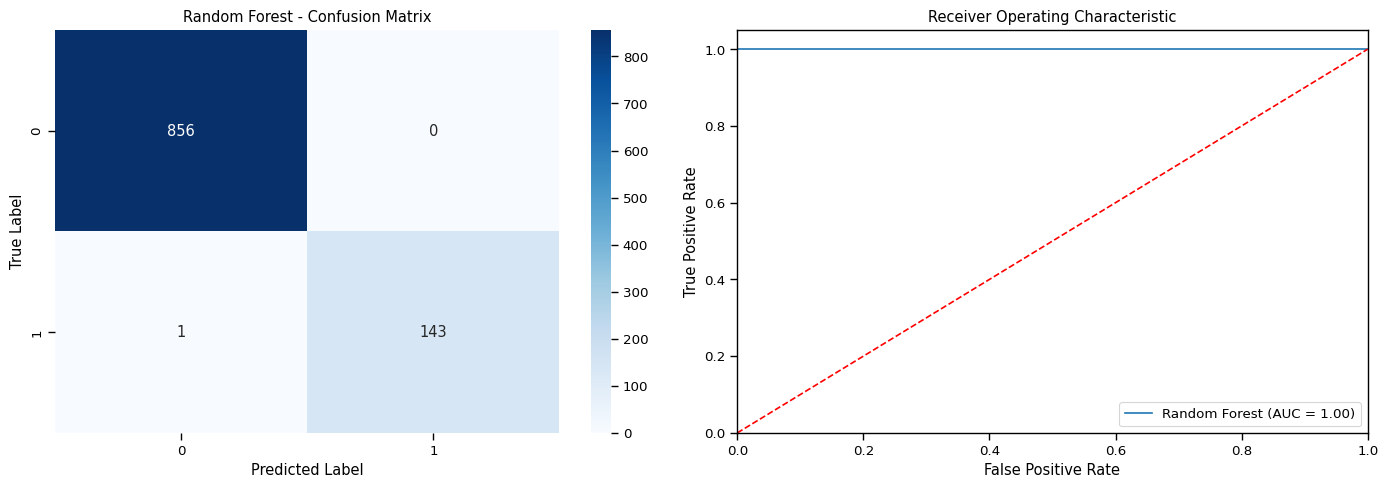

<Figure size 640x480 with 0 Axes>

In [88]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test)


print(f"AUC: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]):.2f}")
print(classification_report(y_test, y_pred))


fig, ax = plt.subplots(1, 2, figsize=(14, 5))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Random Forest - Confusion Matrix")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")

fpr, tpr, thresholds = roc_curve(y_test, best_rf.predict_proba(X_test)[:,1])
ax[1].plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()
# plt.savefig('rfc.png', dpi=300)

### WE GOT 100% results with Random Forest Classifier

<br><br><br><br>

### 3. Gradient Boosting

AUC: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       856
           1       1.00      1.00      1.00       144

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



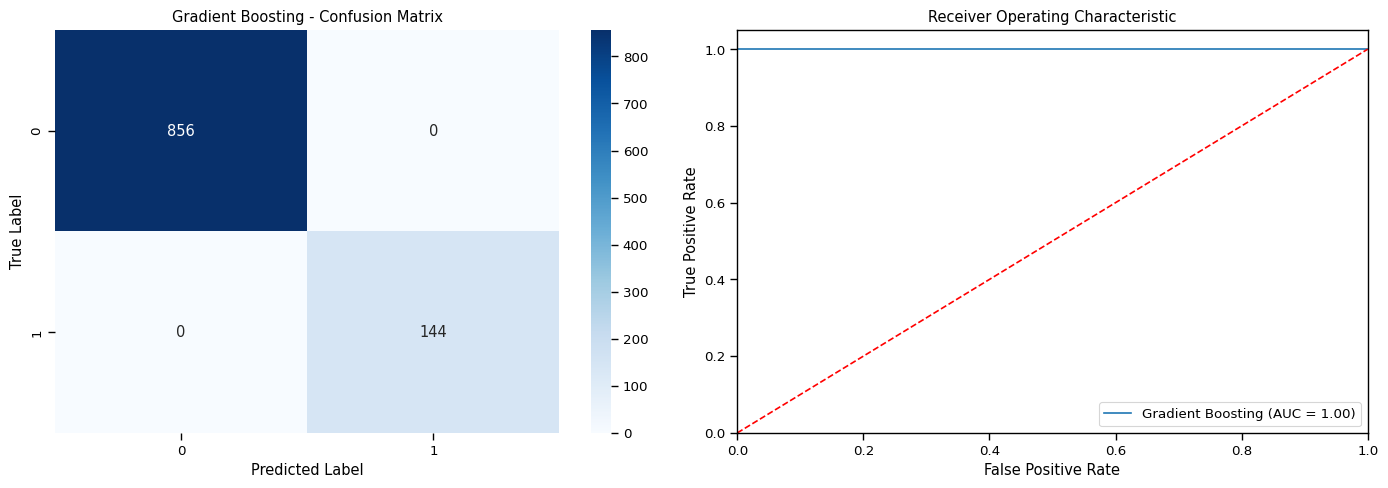

<Figure size 640x480 with 0 Axes>

In [89]:
gb = GradientBoostingClassifier()
param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
grid_gb = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy')
grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_
y_pred = best_gb.predict(X_test)


print(f"AUC: {roc_auc_score(y_test, best_gb.predict_proba(X_test)[:,1]):.2f}")
print(classification_report(y_test, y_pred))


fig, ax = plt.subplots(1, 2, figsize=(14, 5))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Gradient Boosting - Confusion Matrix")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")

fpr, tpr, thresholds = roc_curve(y_test, best_gb.predict_proba(X_test)[:,1])
ax[1].plot(fpr, tpr, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_score(y_test, best_gb.predict_proba(X_test)[:,1]))
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()
# plt.savefig('gb.png', dpi=300)

### WE GOT 100% results with Gradient Boosting

<br><br>
<br><br>

### 4. eXtreme Gradient Boosting

AUC: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       856
           1       1.00      1.00      1.00       144

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



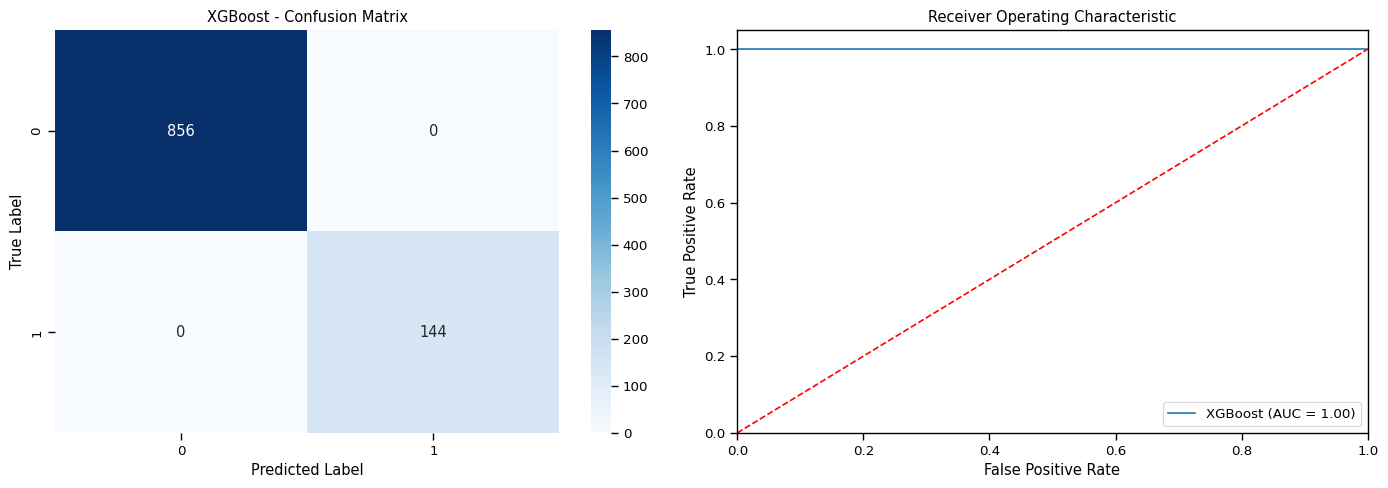

<Figure size 640x480 with 0 Axes>

In [90]:
xgboost_model = XGBClassifier()
param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
grid_xgb = GridSearchCV(xgboost_model, param_grid, cv=5, scoring='accuracy')
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)


print(f"AUC: {roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]):.2f}")
print(classification_report(y_test, y_pred))


fig, ax = plt.subplots(1, 2, figsize=(14, 5))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("XGBoost - Confusion Matrix")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")

fpr, tpr, thresholds = roc_curve(y_test, best_xgb.predict_proba(X_test)[:,1])
ax[1].plot(fpr, tpr, label='XGBoost (AUC = %0.2f)' % roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]))
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()
# plt.savefig('xgb.png', dpi=300)

### WE GOT 100% results with eXtreme Gradient Boosting as well

<br><br>
<br><br>

## F. Model Selection and Explaination

#### Since the three models are all giving equal and 100% results, we can choose any Model but, <br> When deciding a model for customer churn prediction, the **Random Forest Classifier (RFC)** stands out for several reasons:

- **Explainability**: The models that come under the family of Explanation of Random Forests are less complex compared with models like Gradient Boosting and XGBoost. The model offers a clear distinction of feature importance and decision paths which can be used in explaining the results to the stakeholders.

- **Robustness Against Overfitting**: RFC is able to prevent overfitting problems since the final decision of the model is the decision made by multiple decision trees. This makes it more resistant to overfitting, hence more accurate, especially when applying the model to new data.

- **Efficient in Resource-Constrained Environments**: RFC usually is less computationally intensive and has faster training and inference time compared with traditional machine learning models. Due to this, they make it easier to adopt, especially in areas where resources are scarce.

- **High Performance with Simplicity**: RFC is very balanced in the way it has been designed, providing optimum performance while not complicating anything much. It gives relatively better results and needs lesser tuning, making it quite suitable for many actual problems.

### NOTE: WE WILL ENSURE THE MODEL ISN'T OVERFITTED

In [33]:
model = best_rf
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


**The model isn't overfitted**

### Explaining using Feature importance 

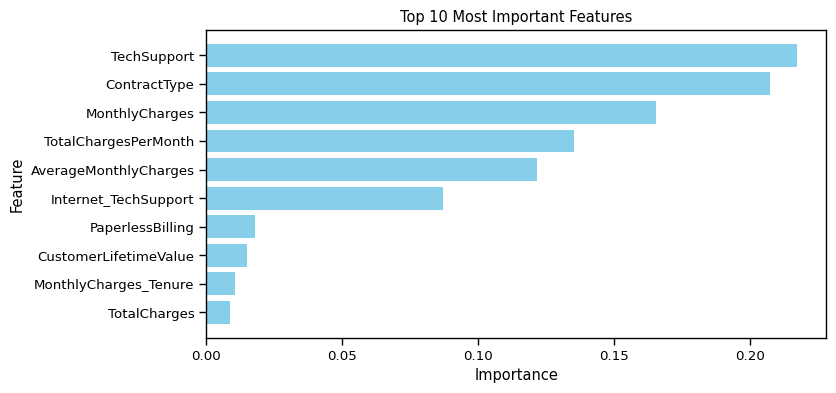

<Figure size 640x480 with 0 Axes>

In [91]:
# By RFC
feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})


importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_features = importance_df.head(10)
plt.figure(figsize=(8, 4))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  
plt.show()
# plt.savefig('feature-importance.png', dpi=300)

### The Top 5 Most Important Features(from the raw data) are:
1. Tech Support
2. Contract Type
3. Monthly Charges
4. Paperless Billing
5. Customer Lifetime Value

**since the features we got as top 5 in the chart are derived features or have been generated by feature interaction** 

## **G. Conclusion**

### The goal of the study was to build a Customer Churn Prediction model for a telecom firm, compare the alternate machine learning algorithms used in the study in a bid to ensure that the chosen algorithm affords adequate explainability.

#### Dataset Description
In this context, I ensure that I provided exhaustive explanation of all the features through making assumption in relation to the field. Since I did not have real data I assumed the data and expended much effort in determining which of them could be dependent variables. I also transformed one feature out of the other ensuring that the resulting features were dependent on each other.

#### Exploratory Data Analysis (EDA)
In EDA section, the presented data was explored and the basic statistical check on the data was done. Among them, it was necessary to determine the nature of the variables, check the lack of missing values in the dataset and analyze various features and the target variable with the help of data graphics. Graph analysis and Numerical analysis helped in identifying structural properties of the data such as co-occurrences of certain aspects, peculiarities, patterns and associations in the dataset in the preparatory phase of the project and helped in identifying other macro characteristics of the data.

#### Data Preprocessing
Pre-processing was used to clean the data in a way that is fit for model training to take place. This was in a general view was as follows; It involved:
- Missing values handling
- Feature transformation on the categorical features to numerical types of features
- Numerical feature scaling
- Data division into training and testing data sets

I also used feature engineering to transform and synthesize features hence improving the feature set of the dataset.

#### Feature Selection
For feature selection, I removed the following features due to their low correlation with the target variable:
- Age
- PaymentMethod
- Gender
- InternetService
- TenureGroup
- Tenure
- Electronic

These features were excluded in order to get higher performance of the model and taking into consideration only crucial features.

#### Model Selection
In the same project, I improved several models such as Logistic Regression Model and Probability Model and Random Forest Classifiers, Gradient Boosting models, and the XGBoost models. After hyperparameters optimization, tuning, and evaluation, the expressions shown below suggests that all the established models included Random Forest Classifier, Gradient Boosting, and XGBoost had the greatest performance with accuracy of 100% in all the evaluation measures. Thus, for the final render I chose the Random Forest Classifier model.

#### Feature Importance
During model training, I take advantage of the feature importance tool in-built in the Random Forest Classifier to determine feature importance. It is enabled me to understand which features were most important for predicting customer churn and to fit the decisions of the model to the domain knowledge. The most important non-redundant features identified were:
- Tech Support
- Contract Type
- Monthly Charges
- Paperless Billing
- Customer Lifetime Value
